In [20]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer 
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/richardph911/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Raw data
label : 1 for negative and 2 for positive

title : review heading

text : review body

In [26]:
def load_data(train_path, test_path):
    try:
        train_df = pd.read_csv(train_path, header=None, names=("label", "title", "text"))
        test_df = pd.read_csv(test_path, header=None, names=("label", "title", "text"))
        train_sample_size = 100000
        test_sample_size = 50000
        if len(train_df) > train_sample_size:
            train_df = train_df.sample(train_sample_size, random_state=42)
        if len(test_df) > test_sample_size:
            test_df = test_df.sample(test_sample_size, random_state=42)

        # 1 → 0 (negative), 2 → 1 (positive)
        label_map = {1: 0, 2: 1}
        train_df['label'] = train_df['label'].map(label_map)
        test_df['label'] = test_df['label'].map(label_map)

        print("Datasets loaded successfully!")
        print(f"Training dataset shape: {train_df.shape}")
        print(f"Test dataset shape: {test_df.shape}")
        return train_df, test_df

    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None, None
    except Exception as e:
        print("Error loading data:", str(e))
        return None, None


In [27]:
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text) if text is not None else ""
    # Remove special characters, URLs, emails in one pass
    text = re.sub(r'\bnot\b\s+(\w+)', r'not_\1', text)
    text = re.sub(r'[^a-zA-Z0-9\s]|https?://\S+|www\.\S+|\S+@\S+', '', text)
    # Tokenize and process
    tokens = text.lower().split()
    sw = set(stopwords.words('english')) - {'not'} 
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in sw]
    return ' '.join(tokens)

In [28]:
def vectorize_text(train_text, test_text):
    # Use HashingVectorizer for memory efficiency
    vectorizer = HashingVectorizer(
        n_features=2**14,
        alternate_sign=False,
        ngram_range=(1, 2),
        norm='l2', 
        stop_words='english'
    )

    # HashingVectorizer doesn't need to be "fit"
    X_train = vectorizer.transform(train_text)
    X_test = vectorizer.transform(test_text)
    total_non_zeros = X_train.nnz + X_test.nnz
    print(f"Total non-zero values in TF-IDF matrices: {total_non_zeros}")

    return X_train, X_test, vectorizer

### Predict review

In [29]:
def predict_review(review, title, model, vectorizer):
    combined_text = (title if title else '') + ' ' + review
    processed_text = preprocess_text(combined_text)
    X_new = vectorizer.transform([processed_text])
    prediction = model.predict(X_new)[0]
    confidence = None
    if hasattr(model, "predict_proba"):
        confidence = model.predict_proba(X_new)[0][1] if prediction == 1 else model.predict_proba(X_new)[0][0]
    
    sentiment = "Good (Positive)" if prediction == 1 else "Bad (Negative)"
    result = f"Predicted result: {sentiment}"
    if confidence is not None:
        result += f"\nConfidence Score: {confidence:.4f}"
    return result

Datasets loaded successfully!
Training dataset shape: (100000, 3)
Test dataset shape: (50000, 3)
Total non-zero values in TF-IDF matrices: 9602217

Running with seed: 42

Training Logistic Regression...
Logistic Regression Test Accuracy: 0.8597

Training Naive Bayes...
Naive Bayes Test Accuracy: 0.8355

Running with seed: 123

Training Logistic Regression...
Logistic Regression Test Accuracy: 0.8584

Training Naive Bayes...
Naive Bayes Test Accuracy: 0.8341

Running with seed: 456

Training Logistic Regression...
Logistic Regression Test Accuracy: 0.8584

Training Naive Bayes...
Naive Bayes Test Accuracy: 0.8369

Best Seed: 456 with average accuracy: 0.8477

Logistic Regression Test Performance (Best Seed 456):
              precision    recall  f1-score   support

           0       0.86      0.85      0.86     25007
           1       0.86      0.86      0.86     24993

    accuracy                           0.86     50000
   macro avg       0.86      0.86      0.86     50000
weighte

/var/folders/dx/dw4w48cs54j90_49_44ls9tw0000gn/T/ipykernel_58745/2777057489.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=model_names, y=accuracies, palette='viridis')


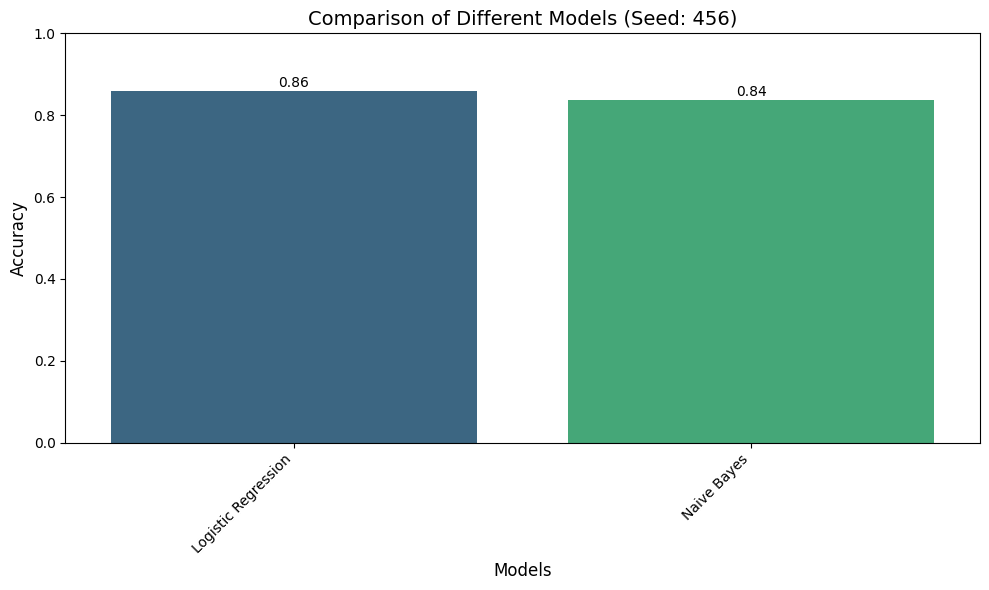


All Seed Results (Average Accuracy Across Models):
Seed 42: 0.8476
Seed 123: 0.8463
Seed 456: 0.8477


In [30]:
if __name__ == "__main__":
    train_path = '/Users/richardph911/Downloads/archive/train.csv' 
    test_path = '/Users/richardph911/Downloads/archive/test.csv' 
    train_df, test_df = load_data(train_path, test_path)
    # Preprocess the text
    if train_df is not None and test_df is not None:
        # Combine title + text, then preprocess
        train_df['reviews'] = train_df['title'].astype(str).fillna('') + ' ' + train_df['text'].astype(str).fillna('')
        test_df['reviews'] = test_df['title'].astype(str).fillna('') + ' ' + test_df['text'].astype(str).fillna('')
        train_df['text'] = train_df['reviews'].apply(preprocess_text)
        test_df['text'] = test_df['reviews'].apply(preprocess_text)
        # Drop the temporary combined column
        train_df = train_df.drop(columns=['reviews'])
        test_df = test_df.drop(columns=['reviews'])
        
        # Vectorize
        X_train_full, X_test, vectorizer = vectorize_text(train_df['text'], test_df['text'])
        y_train_full = train_df['label'].values
        y_test = test_df['label'].values
        
        # Define models
        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "Naive Bayes": MultinomialNB(),
           
            # "KNN": KNeighborsClassifier(n_neighbors=5),
            # "Decision Tree": DecisionTreeClassifier(),
            # "Random Forest": RandomForestClassifier(n_estimators=100)
        }
        # Run 5 epochs with different seeds
        seeds = [42, 123, 456]
        seed_results = {}
        all_accuracies = {name: [] for name in models.keys()}

        for seed in seeds:
            print(f"\nRunning with seed: {seed}")
            # Split data with current seed
            X_train, X_val, y_train, y_val = train_test_split(
                X_train_full, y_train_full, test_size=0.2, random_state=seed, stratify=y_train_full
            )

            accuracies = []
        
            # Train and evaluate models
            for name, model in models.items():
                print(f"\nTraining {name}...")
                model.fit(X_train, y_train)
               
                # Test performance
                y_test_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_test_pred)
                accuracies.append(accuracy)
                all_accuracies[name].append(accuracy)
                print(f"{name} Test Accuracy: {accuracy:.4f}")
                # print(f"\n{name} Test Performance:")
                # print(classification_report(y_test, y_test_pred))
            seed_results[seed] = np.mean(accuracies)

        # Find best seed
        best_seed = max(seed_results, key=seed_results.get)
        print(f"\nBest Seed: {best_seed} with average accuracy: {seed_results[best_seed]:.4f}")

        # re-run with best seed for final visualization
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, test_size=0.2, random_state=best_seed, stratify=y_train_full
        )
        accuracies = []
        model_names = list(models.keys())
        trained_models = {}

        for name, model in models.items():
            model.fit(X_train, y_train)
            trained_models[name] = model
            y_test_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_test_pred)
            accuracies.append(accuracy)
            print(f"\n{name} Test Performance (Best Seed {best_seed}):")
            print(classification_report(y_test, y_test_pred))

            # if hasattr(model, "predict_proba"):
            #     y_test_proba = model.predict_proba(X_test)[:, 1]
            #     print(f"{name} Test Confidence Scores (first 5 samples):")
            #     print(y_test_proba[:5])
            # else:
            #     print(f"{name} does not support confidence scores.")

        # Find best model
        best_model_name = model_names[np.argmax(accuracies)]
        best_model = trained_models[best_model_name]
        print(f"\nBest Model: {best_model_name} with Test Accuracy: {max(accuracies):.4f}")

        # Plot
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=model_names, y=accuracies, palette='viridis')
        plt.xlabel('Models', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title(f'Comparison of Different Models (Seed: {best_seed})', fontsize=14)
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha='right', fontsize=10)

        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black',
                        xytext=(0, 6), textcoords='offset points')

        plt.tight_layout()
        plt.show()

        # Print all seed results
        print("\nAll Seed Results (Average Accuracy Across Models):")
        for seed, avg_acc in seed_results.items():
            print(f"Seed {seed}: {avg_acc:.4f}")




In [31]:
reviews_to_predict = [
            {
                "title": "ACTUALLY NO STARS for rating pf Funny People movie",
                "text": "Save your money. Your time can be MUCH better spent. This was one of the worse movies I ever sat through. Actually, I drifted away close to the end and was thankful I didn't waste that time. Its AWFUL."
            },
            {
                "title" :  "What happend Sandler?",
                "text" :"His movies seem to be going down hill. The only thing i found funny about this movie was Eminem snapping in it. Other then that, it is just not that funny. Dont let it trick you, only see this if its free."

            },
            {
                "title": "Not Funny People",
                "text": "Not worth the time.Pros: there were several good one-liners; introduced me to new comediansCons: excess foul language; adultry;"
            },
            {
                "title": "Very inspirational",
                "text": "So I just watched Funny People. For a movie that has an all star cast, it was a great movie. If you want to see a movie filled with laughs and a good story pick this movie up. I promise you won't regret it."
            },
            {
                "title": "Sfar's Best!",
                "text": "A delightfully funny story! A wonderful graphic novel that gives us a cat's-eye view of the Sephardic Jewish community in Algeria and then the Algerian community in Paris in the early 20th Century. It's a love story. Very funny and endearing. And the hero is a cat! This is a must for Joann Sfar fans."
            },
            {
                "title": "The Rabbi's Cat is the cat's meow!",
                "text": "This book came highly recommended to me by my Rabbi's husband. I was not disappointed! I think everyone will love this illustrated novel.Jorma"
            },
            {
                "title": "What happend Sandler?",
                "text": "His movies seem to be going down hill. The only thing i found funny about this movie was Eminem snapping in it. Other then that, it is just not that funny. Dont let it trick you, only see this if its free."
            }
        ]

In [32]:
for review_data in reviews_to_predict:
    title = review_data["title"]
    text = review_data["text"]
    print(f"\nReview: {title} - {text}")
    result = predict_review(text, title, best_model, vectorizer)
    print("Prediction:")
    print(result)


Review: ACTUALLY NO STARS for rating pf Funny People movie - Save your money. Your time can be MUCH better spent. This was one of the worse movies I ever sat through. Actually, I drifted away close to the end and was thankful I didn't waste that time. Its AWFUL.
Prediction:
Predicted result: Bad (Negative)
Confidence Score: 0.9911

Review: What happend Sandler? - His movies seem to be going down hill. The only thing i found funny about this movie was Eminem snapping in it. Other then that, it is just not that funny. Dont let it trick you, only see this if its free.
Prediction:
Predicted result: Bad (Negative)
Confidence Score: 0.5953

Review: Not Funny People - Not worth the time.Pros: there were several good one-liners; introduced me to new comediansCons: excess foul language; adultry;
Prediction:
Predicted result: Good (Positive)
Confidence Score: 0.8885

Review: Very inspirational - So I just watched Funny People. For a movie that has an all star cast, it was a great movie. If you 